In [ ]:
# ===============================================================
# 🧩 1. INSTALL DEPENDENCIES
# ===============================================================
# Run this first cell to install everything you need in Google Colab.

!pip install torch torchvision scikit-image pillow tqdm matplotlib numpy pytorch-msssim



In [ ]:
# ===============================================================
# ⚙️ 2. MOUNT FILES TO DRIVE
# ===============================================================
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive"


'Algo study sheet.gdoc'  'FAI Progress Report.gdoc'  'Untitled document.gdoc'
'Colab Notebooks'	 'Front end project.gdoc'


In [ ]:
# ===============================================================
# ⚙️ 2. IMPORT LIBRARIES AND SET CONFIG
# ===============================================================

import os, json, random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

# Use GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Path setup (edit to match your folders in Drive or Colab)
DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/CS5100_Project"     # root dataset folder containing 'input/' and 'output/'
OUT_DIR   = f"{DATA_ROOT}/FocusAI_data/runs" # where model checkpoints and predictions will be stored
os.makedirs(OUT_DIR, exist_ok=True)

# Training parameters
CROP_SIZE = 384
BATCH_SIZE = 6
EPOCHS = 20
LR = 1e-4
VAL_SPLIT = 0.15
TEST_SPLIT = 0.1
SEED = 42


Device: cuda


In [ ]:
from PIL import Image
import os
import numpy as np

raw_dir = f"{DATA_ROOT}/FocusAI_data/raw"
target_dir = f"{DATA_ROOT}/FocusAI_data/c"

# Get only matched images (same ones you train on)
matched = [f for f in os.listdir(raw_dir)
           if f in os.listdir(target_dir) and not f.startswith('.')]

widths = []
heights = []

for fname in matched:
    path = os.path.join(raw_dir, fname)
    try:
        img = Image.open(path)
        w, h = img.size
        widths.append(w)
        heights.append(h)
    except:
        print("Error reading:", fname)

widths = np.array(widths)
heights = np.array(heights)

print("📸 Training Set Resolution Statistics (Input Raw Images)")
print("------------------------------------------------------")
print(f"Total valid images: {len(widths)}")
print()
print(f"Min Resolution:       {widths.min()} x {heights.min()}")
print(f"Max Resolution:       {widths.max()} x {heights.max()}")
print(f"Median Resolution:    {np.median(widths)} x {np.median(heights)}")
print(f"Mean Resolution:      {widths.mean():.1f} x {heights.mean():.1f}")
print()
print(f"Aspect Ratio (mean):  {(widths/heights).mean():.3f}")
print(f"Portrait images:      {np.sum(heights > widths)}")
print(f"Landscape images:     {np.sum(widths > heights)}")


📸 Training Set Resolution Statistics (Input Raw Images)
------------------------------------------------------
Total valid images: 3206

Min Resolution:       1531 x 1296
Max Resolution:       6080 x 6080
Median Resolution:    3088.0 x 2844.0
Mean Resolution:      3297.5 x 2879.7

Aspect Ratio (mean):  1.221
Portrait images:      1079
Landscape images:     2127


In [ ]:
# ===============================================================
# 🗂️ 3. DATASET PREPARATION (Enhanced with optional color jitter)
# ===============================================================
from torchvision import transforms as T

class PairFolderWithSplit(Dataset):
    def __init__(self, root, split="train", crop=256, limit=None, jitter=None):
        self.root = root
        self.input_dir = os.path.join(root, "FocusAI_data/raw")
        self.output_dir = os.path.join(root, "FocusAI_data/c")
        self.crop = crop
        self.jitter = jitter
        with open(os.path.join(root, "splits.json")) as f:
            self.files = json.load(f)[split]
        if limit is not None:
            self.files = self.files[:limit]
        self.split = split

    def __len__(self):
        return len(self.files)

    def _to_tensor(self, img):
        t = torch.from_numpy(np.asarray(img).astype(np.float32) / 255.0)
        return t.permute(2,0,1).contiguous()

    def __getitem__(self, idx):
        name = self.files[idx]
        x_path = os.path.join(self.input_dir, name)
        y_path = os.path.join(self.output_dir, name)
        x = Image.open(x_path).convert("RGB")
        y = Image.open(y_path).convert("RGB")

        # Resize to common size
        if x.size != y.size:
            target_w, target_h = min(x.size[0], y.size[0]), min(x.size[1], y.size[1])
            x = x.resize((target_w, target_h), Image.LANCZOS)
            y = y.resize((target_w, target_h), Image.LANCZOS)

        x, y = np.array(x), np.array(y)
        H, W = x.shape[:2]
        c = self.crop
        if min(H, W) < c:
            scale = c / min(H, W)
            newH, newW = int(H * scale), int(W * scale)
            x = np.array(Image.fromarray(x).resize((newW, newH), Image.LANCZOS))
            y = np.array(Image.fromarray(y).resize((newW, newH), Image.LANCZOS))
            H, W = newH, newW

        if self.split == "train":
            top = np.random.randint(0, H - c + 1)
            left = np.random.randint(0, W - c + 1)
        else:
            top, left = (H - c)//2, (W - c)//2

        x = x[top:top+c, left:left+c]
        y = y[top:top+c, left:left+c]

        if x.shape != y.shape:
            h = min(x.shape[0], y.shape[0])
            w = min(x.shape[1], y.shape[1])
            x, y = x[:h, :w], y[:h, :w]

        # Apply color jitter only on training inputs
        if self.split == "train" and self.jitter is not None:
            x = Image.fromarray(x)
            x = self.jitter(x)
            x = np.array(x)

        return self._to_tensor(x), self._to_tensor(y)


In [ ]:
# ===============================================================
# 🔀 4. TRAIN/VAL/TEST SPLIT
# ===============================================================

input_files = [f for f in os.listdir(os.path.join(DATA_ROOT, "FocusAI_data/raw")) if not f.startswith(".")]
output_files = set(os.listdir(os.path.join(DATA_ROOT, "FocusAI_data/c")))
common = [f for f in input_files if f in output_files]

random.Random(SEED).shuffle(common)
n = len(common)
n_val = int(VAL_SPLIT * n)
n_test = int(TEST_SPLIT * n)
splits = {
    "val": common[:n_val],
    "test": common[n_val:n_val+n_test],
    "train": common[n_val+n_test:]
}
with open(os.path.join(DATA_ROOT, "splits.json"), "w") as f:
    json.dump(splits, f, indent=2)

print(f"Dataset split: Train={len(splits['train'])}, Val={len(splits['val'])}, Test={len(splits['test'])}")


Dataset split: Train=2406, Val=480, Test=320


In [ ]:
# ===============================================================
# 🧠 5. MODEL DEFINITION – SIMPLE RESIDUAL CNN
# ===============================================================

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        return self.relu(out + x)

class EnhancementCNN(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.entry = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(5)])
        self.exit = nn.Conv2d(64, in_channels, 3, padding=1)
    def forward(self, x):
        base = torch.relu(self.entry(x))
        refined = self.res_blocks(base)
        out = torch.sigmoid(self.exit(refined) + x)  # residual correction
        return out


In [ ]:
#CHECK TO SEE IF ALL FILES ARE CORRECTLY INSERTED/EXISITNG IN THE TRAINING FOLDER
import os

def verify_dataset_pairs(input_dir, target_dir, exts=(".jpg", ".png", ".tif", ".jpeg")):
    """
    Verify that each image in input_dir has a matching image in target_dir.
    Returns lists of missing/mismatched files.
    """
    # Gather file basenames (without extension) for each directory
    def list_files_no_ext(folder):
        return {
            os.path.splitext(f)[0]
            for f in os.listdir(folder)
            if f.lower().endswith(exts) and not f.startswith('.')
        }

    input_set = list_files_no_ext(input_dir)
    target_set = list_files_no_ext(target_dir)

    missing_in_target = sorted(list(input_set - target_set))
    missing_in_input = sorted(list(target_set - input_set))

    print("✅ Dataset Verification Report")
    print(f"Input images found: {len(input_set)}")
    print(f"Target images found: {len(target_set)}")
    print(f"Matching pairs: {len(input_set & target_set)}")
    print(f"❌ Missing in target: {len(missing_in_target)}")
    print(f"❌ Missing in input: {len(missing_in_input)}")

    # Optionally preview a few mismatches
    if missing_in_target:
        print("\nExamples missing in target:", missing_in_target[:5])
    if missing_in_input:
        print("\nExamples missing in input:", missing_in_input[:5])

    return missing_in_target, missing_in_input

# --- Run it ---
missing_target, missing_input = verify_dataset_pairs(f"{DATA_ROOT}/FocusAI_data/raw", f"{DATA_ROOT}/FocusAI_data/c")


✅ Dataset Verification Report
Input images found: 4099
Target images found: 3301
Matching pairs: 3206
❌ Missing in target: 893
❌ Missing in input: 95

Examples missing in target: ['a0009-kme_372', 'a0017-050710_031618__MG_3496', 'a0019-jmac_MG_0653', 'a0022-IMG_2380', 'a0023-07-06-02-at-15h06m48-s_MG_1489']

Examples missing in input: ['a0002-dgw_005', 'a0011-DSC_0082', 'a0078-IMG_0326', 'a0212-IMG_0358', 'a0248-IMG_4976']


In [ ]:
# ===============================================================
# 🎯 6. TRAINING LOOP (Improved – color jitter + SSIM + AMP + cosine LR)
# ===============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_msssim import ssim
from tqdm import tqdm
import torchvision.transforms as T
import json, os, glob
import numpy as np

# --- Filter helper ---
def get_valid_pairs(input_dir, target_dir, exts=(".jpg", ".png", ".tif", ".jpeg")):
    def list_files_no_ext(folder):
        return {os.path.splitext(f)[0] for f in os.listdir(folder)
                if f.lower().endswith(exts) and not f.startswith('.')}
    input_set = list_files_no_ext(input_dir)
    target_set = list_files_no_ext(target_dir)
    valid_names = sorted(list(input_set & target_set))
    valid_input_paths = [
        os.path.join(input_dir, name + ext)
        for name in valid_names for ext in exts
        if os.path.exists(os.path.join(input_dir, name + ext))
    ]
    return valid_input_paths

# --- Mild color jitter ---
color_jitter = T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02)

# --- Combined L1 + SSIM loss ---
def combined_loss(pred, target):
    l1 = nn.L1Loss()(pred, target)
    ssim_loss = 1 - ssim(pred, target, data_range=1.0, size_average=True)
    return 0.8 * l1 + 0.2 * ssim_loss


def train_model():
    train_ds = PairFolderWithSplit(DATA_ROOT, "train", CROP_SIZE, limit=500, jitter=color_jitter)
    val_ds   = PairFolderWithSplit(DATA_ROOT, "val", CROP_SIZE, limit=100)

    tr_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)

    model = EnhancementCNN().to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

    # ✅ Correct AMP scaler for your PyTorch version
    scaler = torch.cuda.amp.GradScaler()

    best_ssim = 0.0
    for ep in range(1, EPOCHS + 1):
        model.train()
        train_loss = 0.0

        for x, y in tqdm(tr_loader, desc=f"Epoch {ep}/{EPOCHS}"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()

            # ✅ Correct autocast syntax
            with torch.cuda.amp.autocast():
                y_hat = model(x)
                loss = combined_loss(y_hat, y)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            train_loss += loss.item()

        train_loss /= len(tr_loader)
        scheduler.step()

        # --- Validation (unchanged) ---
        model.eval()
        val_ssim, val_psnr = 0.0, 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = model(x)

                # Convert to numpy
                out_np = out.squeeze(0).permute(1,2,0).cpu().numpy().astype(np.float32)
                y_np   = y.squeeze(0).permute(1,2,0).cpu().numpy().astype(np.float32)

                # SSIM expects tensors
                out_t = torch.tensor(out_np).permute(2,0,1).unsqueeze(0)
                y_t   = torch.tensor(y_np).permute(2,0,1).unsqueeze(0)

                val_ssim += float(ssim(out_t, y_t, data_range=1.0, size_average=True))
                val_psnr += psnr(out_np, y_np, data_range=1.0)

        val_ssim /= len(val_loader)
        val_psnr /= len(val_loader)

        print(f"[VAL] Ep{ep}: Loss={train_loss:.4f} SSIM={val_ssim:.3f} PSNR={val_psnr:.2f} dB")

        if val_ssim > best_ssim:
            best_ssim = val_ssim
            torch.save(model.state_dict(), f"{OUT_DIR}/best.pt")
            print("  -> 💾 Saved best model")

    print("✅ Training complete. Best SSIM:", best_ssim)


# --- Filter & prepare splits ---
valid_inputs = get_valid_pairs(f"{DATA_ROOT}/FocusAI_data/raw", f"{DATA_ROOT}/FocusAI_data/c")
print(f"✅ Found {len(valid_inputs)} valid pairs for training.")

with open(os.path.join(DATA_ROOT, "valid_files.txt"), "w") as f:
    for path in valid_inputs:
        f.write(os.path.basename(path) + "\n")

print("🧹 Filtered file list saved to valid_files.txt")

split_path = os.path.join(DATA_ROOT, "split.json")
if os.path.exists(split_path):
    with open(split_path, "r") as f:
        splits = json.load(f)
    valid_basenames = {os.path.splitext(os.path.basename(p))[0] for p in valid_inputs}
    for key in splits.keys():
        splits[key] = [x for x in splits[key]
                       if os.path.splitext(os.path.basename(x))[0] in valid_basenames]
    with open(split_path, "w") as f:
        json.dump(splits, f, indent=2)
    print("✅ split.json updated with filtered pairs.")
else:
    print("⚠️ split.json not found — continuing with internal dataset split logic.")

# --- Run training ---
train_model()


/tmp/ipython-input-625710977.py:51: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


✅ Found 3206 valid pairs for training.
🧹 Filtered file list saved to valid_files.txt
⚠️ split.json not found — continuing with internal dataset split logic.


Epoch 1/20:   0%|          | 0/84 [00:00<?, ?it/s]/tmp/ipython-input-625710977.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/20: 100%|██████████| 84/84 [04:41<00:00,  3.36s/it]


[VAL] Ep1: Loss=0.4666 SSIM=0.399 PSNR=3.82 dB
  -> 💾 Saved best model


Epoch 2/20: 100%|██████████| 84/84 [04:20<00:00,  3.11s/it]


[VAL] Ep2: Loss=0.5995 SSIM=0.399 PSNR=3.82 dB


Epoch 3/20: 100%|██████████| 84/84 [04:21<00:00,  3.11s/it]


[VAL] Ep3: Loss=0.6275 SSIM=0.399 PSNR=3.82 dB


Epoch 4/20: 100%|██████████| 84/84 [04:22<00:00,  3.12s/it]


[VAL] Ep4: Loss=0.6200 SSIM=0.399 PSNR=3.82 dB


Epoch 5/20: 100%|██████████| 84/84 [04:21<00:00,  3.12s/it]


[VAL] Ep5: Loss=0.6133 SSIM=0.399 PSNR=3.82 dB


Epoch 6/20: 100%|██████████| 84/84 [04:25<00:00,  3.16s/it]


[VAL] Ep6: Loss=0.6189 SSIM=0.399 PSNR=3.82 dB


Epoch 7/20: 100%|██████████| 84/84 [04:27<00:00,  3.18s/it]


[VAL] Ep7: Loss=0.6222 SSIM=0.399 PSNR=3.82 dB


Epoch 8/20: 100%|██████████| 84/84 [04:22<00:00,  3.13s/it]


[VAL] Ep8: Loss=0.6164 SSIM=0.399 PSNR=3.82 dB


Epoch 9/20:  37%|███▋      | 31/84 [01:38<03:04,  3.48s/it]

✅ Loaded model: /content/drive/MyDrive/Colab Notebooks/CS5100_Project/FocusAI_data/runs/best.pt
⚠️ Warning: Target not found for a1141-kme_262.jpg
🎨 Sample chosen: a1141-kme_262.jpg


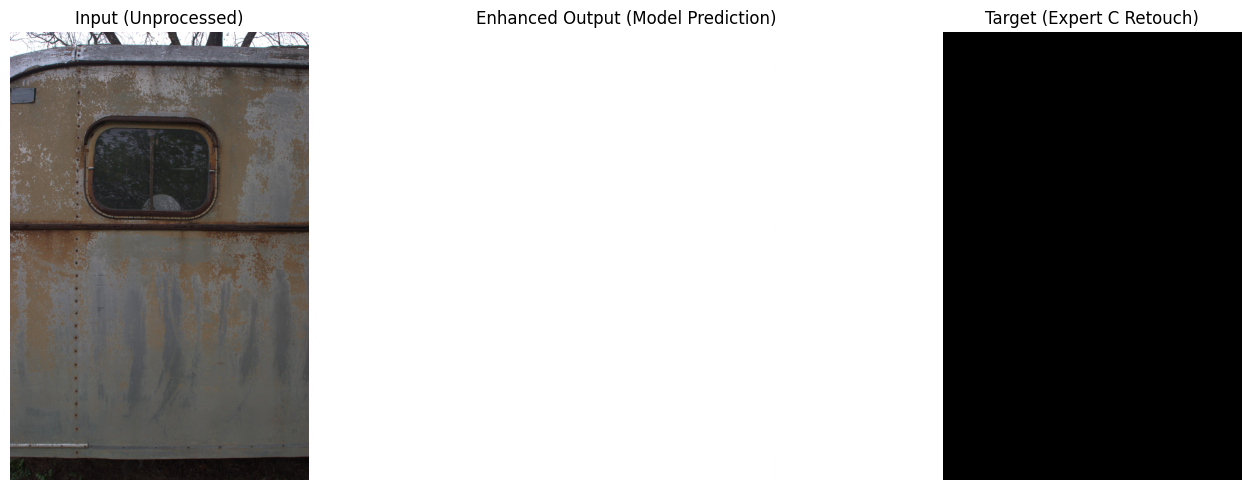

In [ ]:
# ===============================================================
# 🔍 7. INFERENCE AND VISUALIZATION (Random Input → Output → Target)
# ===============================================================

import random

def load_model():
    model = EnhancementCNN().to(DEVICE)
    ckpt = f"{OUT_DIR}/best.pt"
    model.load_state_dict(torch.load(ckpt, map_location=DEVICE))
    model.eval()
    print("✅ Loaded model:", ckpt)
    return model


def enhance_image(model, input_path, target_dir):
    """Runs inference on an input image and returns input, prediction, and target arrays."""
    # --- Load input ---
    inp_img = Image.open(input_path).convert("RGB")
    inp_arr = np.array(inp_img).astype(np.float32) / 255.0

    # --- Load target ---
    base_name = os.path.basename(input_path)
    target_path = os.path.join(target_dir, base_name)
    if not os.path.exists(target_path):
        print(f"⚠️ Warning: Target not found for {base_name}")
        target_arr = np.zeros_like(inp_arr)
    else:
        target_img = Image.open(target_path).convert("RGB")
        target_arr = np.array(target_img).astype(np.float32) / 255.0

    # --- Run model ---
    t = torch.tensor(inp_arr).permute(2,0,1).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out = model(t).squeeze(0).permute(1,2,0).clamp(0,1).cpu().numpy()
    return inp_arr, out, target_arr


# --- Run Inference ---
model = load_model()

# Choose a random image from the raw folder
raw_dir = os.path.join(DATA_ROOT, "FocusAI_data/raw")
target_dir = os.path.join(DATA_ROOT, "FocusAI_data/c")
all_files = [f for f in os.listdir(raw_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif'))]
sample_file = os.path.join(raw_dir, random.choice(all_files))

inp, out, tgt = enhance_image(model, sample_file, target_dir)

# --- Display ---
print(f"🎨 Sample chosen: {os.path.basename(sample_file)}")
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(inp)
plt.title("Input (Unprocessed)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(out)
plt.title("Enhanced Output (Model Prediction)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(tgt)
plt.title("Target (Expert C Retouch)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# import torch
# print("CUDA available:", torch.cuda.is_available())
# print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")
